# 2. Keypoints using MP Holistic and Face Mesh

In [3]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np
import os
import time

# Initialize MediaPipe components
mp_face_mesh = mp.solutions.face_mesh
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Initialize the Holistic model with increased confidence and smoothing
holistic = mp_holistic.Holistic(
    min_detection_confidence=0.7,  # Increase detection confidence
    min_tracking_confidence=0.7,   # Increase tracking confidence
    smooth_landmarks=True          # Enable smoothing of landmarks
)

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

def draw_landmarks(image, results):
    # Draw face landmarks
    if results.face_landmarks:
        mp_drawing.draw_landmarks(
            image,
            results.face_landmarks,
            mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style()
        )

    # Draw pose landmarks
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            image,
            results.pose_landmarks,
            mp_holistic.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style()
        )

    # Draw left hand landmarks
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            image,
            results.left_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style()
        )

    # Draw right hand landmarks
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            image,
            results.right_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style()
        )

def smooth_landmarks(landmarks, prev_landmarks, smoothing_factor=0.8):
    """Smooth landmarks using an exponential moving average."""
    if prev_landmarks is None:
        return landmarks
    smoothed_landmarks = []
    for current, previous in zip(landmarks, prev_landmarks):
        smoothed_landmark = previous * (1 - smoothing_factor) + current * smoothing_factor
        smoothed_landmarks.append(smoothed_landmark)
    return smoothed_landmarks

cap = cv2.VideoCapture(0)
results = None  # Initialize results as None
last_frame = None  # Initialize last_frame as None
prev_landmarks = None  # To store previous landmarks for smoothing

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Use Holistic model for detection
    image, holistic_results = mediapipe_detection(frame, holistic)

    # Extract and smooth landmarks if available
    if holistic_results.pose_landmarks:
        landmarks = np.array([(lm.x, lm.y, lm.z) for lm in holistic_results.pose_landmarks.landmark])
        smoothed_landmarks = smooth_landmarks(landmarks, prev_landmarks)
        prev_landmarks = smoothed_landmarks

        # Update the smoothed landmarks in the results object
        for idx, lm in enumerate(holistic_results.pose_landmarks.landmark):
            lm.x, lm.y, lm.z = smoothed_landmarks[idx]

    draw_landmarks(image, holistic_results)

    # Store the latest results and frame
    results = holistic_results
    last_frame = image.copy()  # Store a copy of the last frame
    
    # Display using OpenCV
    cv2.imshow('Output', image)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()




d:\edit assets\projectfiles\ASLGOBRR\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


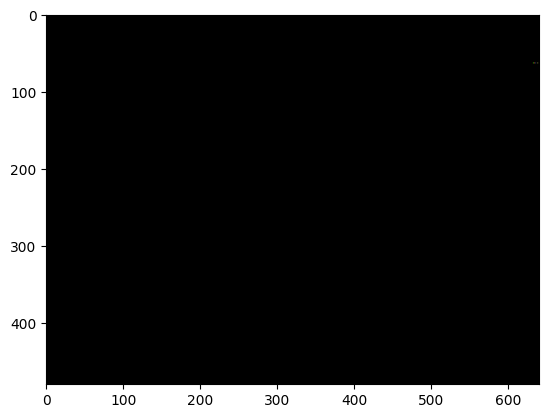

In [2]:
plt.imshow(cv2.cvtColor(last_frame, cv2.COLOR_BGR2RGB)) #prints out the last fame with adapt colours
plt.show()

# 3. Extract Keypoint Values

In [16]:
len(results.left_hand_landmarks.landmark)

21

In [17]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [18]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [19]:
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() 
    #if result.face_landmarks 
    #else np.zeros(1404)


In [21]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [22]:
result_test = extract_keypoints(results)

In [16]:
result_test

array([ 0.33663195,  0.67725849, -0.70926714, ...,  0.        ,
        0.        ,  0.        ])

In [23]:
468*3+33*4+21*3+21*3

1662

In [24]:
np.save('0', result_test)

In [25]:
np.load('0.npy')

array([ 0.2657114 ,  0.41034466, -0.71443307, ...,  0.        ,
        0.        ,  0.        ])

# 4. Setup Folders for Collection

In [26]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [ ]:
# hello
## 0
## 1
## 2
## ...
## 29
# thanks

# I love you

In [17]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
label_map = {label:num for num, label in enumerate(actions)}

In [ ]:
label_map

In [ ]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [ ]:
np.array(sequences).shape

In [ ]:
np.array(labels).shape

In [ ]:
X = np.array(sequences)

In [ ]:
X.shape

In [ ]:
y = to_categorical(labels).astype(int)

In [ ]:
y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [ ]:
y_test.shape

# 7. Build and Train LSTM Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [ ]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [ ]:
res = [.7, 0.2, 0.1]

In [ ]:
actions[np.argmax(res)]

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

In [ ]:
model.summary()

# 8. Make Predictions

In [ ]:
res = model.predict(X_test)

In [ ]:
actions[np.argmax(res[4])]

In [ ]:
actions[np.argmax(y_test[4])]

# 9. Save Weights

In [ ]:
model.save('action.h5')

In [ ]:
del model

In [ ]:
model.load_weights('action.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [ ]:
yhat = model.predict(X_test)

In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

In [ ]:
accuracy_score(ytrue, yhat)

# 11. Test in Real Time

In [ ]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [ ]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [ ]:
sequence.reverse()

In [ ]:
len(sequence)

In [ ]:
sequence.append('def')

In [ ]:
sequence.reverse()

In [ ]:
sequence[-30:]

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

In [ ]:
res[np.argmax(res)] > threshold

In [ ]:
(num_sequences,30,1662)

In [ ]:
model.predict(np.expand_dims(X_test[0], axis=0))